In [1]:
# IMPORTS
import os
import wandb
from datetime import timedelta, datetime, date

import os.path
import subprocess
import copy
import time
from time import sleep
import calendar

from dateutil import parser
import json
import hashlib
import re
import gc
import joblib
import numbers
import math
import numpy as np
import pandas as pd
import random
from pandas import DataFrame



import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from transformers import *

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook
from tqdm.auto import trange, tqdm

import seaborn as sns
from IPython.display import clear_output, display, Javascript
from typing import List,Union,Any
from functools import partial, reduce
from six.moves import urllib
import matplotlib.pyplot as plt

from binance.client import Client
import GetOldTweets3 as got #https://github.com/Mottl/GetOldTweets3/tree/master/GetOldTweets3/manager
from pandas_datareader import data as pdr
from pytrends.request import TrendReq
import yfinance as yf


yf.pdr_override()



# Login to Google. Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
nlpmodel = BertModel.from_pretrained('bert-base-uncased')

out = subprocess.Popen(['nordvpn', 'countries'], 
           stdout=subprocess.PIPE, 
           stderr=subprocess.STDOUT)

stdout,stderr = out.communicate()
servers = stdout.decode("utf-8").replace("\r","").replace("\n","").replace(" ","").replace("-","").split(",")
binance_api_key = ""#Fill
binance_api_secret = ""#Fill
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

def minutes_of_new_data(symbol, kline_size, data, start):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    else: old = start
    new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

def get_all_binance(symbol, kline_size,start, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, start)
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

def show_confusion_matrix(cm,saveFile=None,show=True):
    labels=[str(pairs[i]) for i in range(len(pairs))]
    labels.append("N")
    cm_df = pd.DataFrame(cm,labels,labels)
    ax = sns.heatmap(cm_df, annot=True,fmt='.5g')
    ax.set_xlabel('predicted')
    ax.set_ylabel('target')
    res = wandb.Image(ax)
    if saveFile is not None:
        plt.savefig(saveFile)
    if show:
        plt.show()
    plt.close()
    return res

def ifnone(a:Any,b:Any)->Any:
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def make_date(df:DataFrame, date_field:str):
    "Make sure `df[field_name]` is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)

def cyclic_dt_feat_names(time:bool=True, add_linear:bool=False)->List[str]:
    "Return feature names of date/time cycles as produced by `cyclic_dt_features`."
    fs = ['cos','sin']
    attr = [f'{r}_{f}' for r in 'weekday day_month month_year day_year'.split() for f in fs]
    if time: attr += [f'{r}_{f}' for r in 'hour clock min sec'.split() for f in fs]
    if add_linear: attr.append('year_lin')
    return attr

def cyclic_dt_features(d:Union[date,datetime], time:bool=True, add_linear:bool=False)->List[float]:
    "Calculate the cos and sin of date/time cycles."
    tt,fs = d.timetuple(), [np.cos, np.sin]
    day_year,days_month = tt.tm_yday, calendar.monthrange(d.year, d.month)[1]
    days_year = 366 if calendar.isleap(d.year) else 365
    rs = d.weekday()/7, (d.day-1)/days_month, (d.month-1)/12, (day_year-1)/days_year
    feats = [f(r * 2 * np.pi) for r in rs for f in fs]
    if time and isinstance(d, datetime) and type(d) != date:
        rs = tt.tm_hour/24, tt.tm_hour%12/12, tt.tm_min/60, tt.tm_sec/60
        feats += [f(r * 2 * np.pi) for r in rs for f in fs]
    if add_linear:
        if type(d) == date: feats.append(d.year + rs[-1])
        else:
            secs_in_year = (datetime(d.year+1, 1, 1) - datetime(d.year, 1, 1)).total_seconds()
            feats.append(d.year + ((d - datetime(d.year, 1, 1)).total_seconds() / secs_in_year))
    return feats

def add_cyclic_datepart(df:DataFrame, field_name:str, prefix:str=None, drop:bool=True, time:bool=False, add_linear:bool=False):
    "Helper function that adds trigonometric date/time features to a date in the column `field_name` of `df`."
    make_date(df, field_name)
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    series = field.apply(partial(cyclic_dt_features, time=time, add_linear=add_linear))
    columns = [prefix + c for c in cyclic_dt_feat_names(time, add_linear)]
    df_feats = pd.DataFrame([item for item in series], columns=columns, index=series.index)
    for column in columns: df[column] = df_feats[column]
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

def date_converter(o):
    if isinstance(o, datetime):
        return o.__str__()

In [2]:
# os.environ['WANDB_MODE']="dryrun"
wandb.init(project="crypto")

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: mefmef (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.10.0rc3
wandb: Syncing run flowing-yogurt-94
wandb: ⭐️ View project at https://app.wandb.ai/mefmef/crypto
wandb: 🚀 View run at https://app.wandb.ai/mefmef/crypto/runs/3mayp5m1


In [3]:
%%script false --no-raise-error #To skip this cell execution

symbols2get = ["BTCUSDT", "XRPBTC", "ETHBTC", "LTCBTC"]
kw_list = ["bitcoin", "gold", "stock market","ethereum"]
fileName = "OneDayClassifyWithBERT.csv"
forceReload = True
if not os.path.exists(fileName) or forceReload:
    print("Satrt fetching binance data!")
    df_orig = None
    for s in tqdm(symbols2get):
        if df_orig is None:
            start = datetime.strptime('1 jan 2017', '%d %b %Y')
        else:
            start = datetime.strptime(str(df_orig.index[0].date()),'%Y-%m-%d')
        dftmp = get_all_binance(s, '1d', save = False,start=start)
        dftmp = dftmp[dftmp.ignore != 0]
        dftmp.drop("ignore", axis=1, inplace=True)
        dftmp['avg'] = dftmp[['high', 'low']].astype(float).mean(axis=1)
        dftmp.columns = dftmp.columns.map(lambda x : s+"_"+x if x !='timestamp' else x)
        if df_orig is not None:
            df_orig = df_orig.merge(dftmp, on='timestamp')
        else:
            df_orig = dftmp.copy()
        del dftmp
        
    df_orig.to_csv(fileName)
    df_orig = pd.read_csv(fileName,index_col=0)
    
    print("Satrt fetching yahoo finance data!")
    
    dftmp = pdr.get_data_yahoo("CL=F GOLD ^GSPC EURUSD=X BAC NRT SLV", start=df_orig.index[0], end="2023-01-01")
    idx = pd.date_range(df_orig.index[0], datetime.now().strftime("%Y-%m-%d"))
    dftmp.index = pd.DatetimeIndex(dftmp.index)
    dftmp = dftmp.reindex(idx, method='nearest')
    dftmp=dftmp.fillna(method='ffill')
    dftmp.columns =  ['_'.join(x) for x in dftmp.columns.ravel()]
    dftmp.index=dftmp.index.rename("timestamp").astype(str)
    df_orig=df_orig.merge(dftmp, on='timestamp')
    del dftmp 
    
    df_orig.to_csv(fileName)
    df_orig = pd.read_csv(fileName,index_col=0)
    
    print("Satrt fetching google trends data!")
    
    startday = datetime.strptime(str(df_orig.index[0]),'%Y-%m-%d')
    endday = datetime.strptime(str(df_orig.index[-1]),'%Y-%m-%d')
    res = pytrend.get_historical_interest(kw_list, year_start=startday.year, month_start=startday.month, day_start=startday.day, hour_start=0, year_end=endday.year, month_end=endday.month, day_end=endday.day, hour_end=0, cat=0, geo='', gprop='', sleep=60)
    g = res.astype(float).groupby(pd.Grouper(freq="D"))
    dftmp = g.aggregate({t:np.mean for t in kw_list})
    idx = pd.date_range(df_orig.index[0], datetime.now().strftime("%Y-%m-%d"))
    dftmp.index = pd.DatetimeIndex(dftmp.index)
    dftmp = dftmp.reindex(idx, method='nearest')
    dftmp = dftmp.fillna(method='ffill')
    dftmp.index = dftmp.index.rename("timestamp").astype(str)
    df_orig = df_orig.merge(dftmp, on='timestamp')
    del dftmp
    
    print("Check NA:",(len(df_orig) - df_orig.count()).sum(),df_orig.isnull().T.any().T.sum(),df_orig.isnull().T.any().T.sum())
    df_orig = df_orig.dropna()
    
    df_orig.to_csv(fileName)
    df_orig = pd.read_csv(fileName,index_col=0)
    
else:
    df_orig = pd.read_csv(fileName,index_col=0) 


wandb.save(fileName)
jfileName = "bigTweet.json"
forceReloadTweet = False #Dont need to put to True unless you want to chane parameters
minNumTweet = 20
if not os.path.exists(jfileName) or forceReloadTweet:
    bigTweet = {}
else:
    with open(jfileName, "r") as read_file:
        bigTweet = json.load(read_file)

        
for i,d in enumerate(tqdm(df_orig.index)):
    if(type(d) is pd._libs.tslibs.timestamps.Timestamp):
        today = d.date()
    else:
        today = datetime.strptime(str(d), '%Y-%m-%d').date()
        
    tommorow = today+timedelta(1)
    
    if today.strftime("%Y-%m-%d") in bigTweet.keys():
        if tommorow.strftime("%Y-%m-%d") in bigTweet.keys():
            continue
        else: #update the last one
            del bigTweet[today.strftime("%Y-%m-%d")]

    okTweet = False
    while not okTweet:
        try:
            tweetCriteria = got.manager.TweetCriteria().setQuerySearch("bitcoin")\
                                                       .setLang("en")\
                                                       .setSince(today.strftime("%Y-%m-%d"))\
                                                       .setUntil(tommorow.strftime("%Y-%m-%d"))\
                                                       .setMinReplies("1")\
                                                       .setMinRetweets("10")\
                                                       .setMinFaves("1")\
                                                       .setMaxTweets(50)\
                                                       .setTopTweets(True)\
                                                       .setEmoji("name")
            tweets = got.manager.TweetManager.getTweets(tweetCriteria)
            if len(tweets)>minNumTweet:
                okTweet = True
            else:
                print("Too few tweet",len(tweets))
        except:
#             newC=random.choice(servers)
#             os.system("nordvpn c "+newC)
#             print("Change server to "+newC+"!")
            sleep(random.randint(60,300))
            pass
    bigTweet[str(today)] = []
    for j,t in enumerate(tweets):
        bigTweet[str(today)].append(t.__dict__)



assert len(bigTweet.keys()) == len(df_orig)

with open(jfileName, 'w') as fp:
    json.dump(bigTweet, fp,default = date_converter)
    print("saved in "+jfileName)
    wandb.save(jfileName)
    
dateList = []
def getDateFromIndex(index):
    return dateList[index]
def getIndexFromDate(date):
    return dateList.index(date)

for d in df_orig.index:
    if(type(d) is pd._libs.tslibs.timestamps.Timestamp):
        dtime = str(d.date())
    else:
        dtime = d
    dateList.append(dtime)
    
ttfileName = "bigTweetTensor.t"
if not os.path.exists(ttfileName) or forceReload:
    bigTweetTensor = torch.zeros((len(df_orig),tokenizer.max_len,nlpmodel.embeddings.word_embeddings.embedding_dim))
    for t in tqdm(bigTweet):
        rtweets = random.sample(bigTweet[t], minNumTweet)
        text = ""
        for rt in rtweets:
            text += rt['username']+" "+rt['text']
        tok = torch.tensor([tokenizer.encode(text, add_special_tokens=True,padding='max_length',truncation=True)])
        with torch.no_grad():
            last_hidden_states = nlpmodel(tok)[0]
            bigTweetTensor[getIndexFromDate(t)] = last_hidden_states
    torch.save(bigTweetTensor,ttfileName)
    wandb.save(ttfileName)
else:
    bigTweetTensor = torch.load(ttfileName)
    
wandb.save(ttfileName)

colToShow = []
for c in df_orig.columns:
    if "_avg" in c:
        colToShow.append(c.replace("_avg",""))
        
for c in colToShow:
        p = df_orig[:].plot(use_index=True, y=[c+'_open', c+'_high',c+"_low", c+'_close',c+'_avg'], figsize=(10,5), grid=False)
        wandb.log({"beforeScale_"+c:wandb.Image(p)})
        plt.show()

In [4]:
df_orig = pd.read_csv("OneDayClassifyWithBERT.csv",index_col=0) 

bigTweetTensor = torch.load("bigTweetTensor.t")

ap = nn.AvgPool1d(4, stride=4)
with torch.no_grad():
    print("Before pooling:",bigTweetTensor.shape)
    bigTweetTensor = ap(ap(bigTweetTensor.permute(0,2,1)).permute(0,2,1))
    print("After pooling:",bigTweetTensor.shape)
    tweetDim = bigTweetTensor[0].shape[0]*bigTweetTensor[0].shape[1]

dateList = []
def getDateFromIndex(index):
    return dateList[index]
def getIndexFromDate(date):
    return dateList.index(date)

for d in df_orig.index:
    if(type(d) is pd._libs.tslibs.timestamps.Timestamp):
        dtime = str(d.date())
    else:
        dtime = d
    dateList.append(dtime)
    
df_orig = df_orig.reset_index()
add_cyclic_datepart(df_orig, "timestamp", drop=True)
df_orig = df_orig.astype(float)

column_names_to_normalize = list(df_orig.columns)
min_max_scaler=preprocessing.MaxAbsScaler()

#Normalize
x = df_orig[column_names_to_normalize].values
dfn = df_orig.copy()
dfn[column_names_to_normalize] = pd.DataFrame(min_max_scaler.fit_transform(x), columns=column_names_to_normalize, index = df_orig.index)

#Un normalize
x = dfn[column_names_to_normalize].values
dfnn = df_orig.copy()
dfnn[column_names_to_normalize] = pd.DataFrame(min_max_scaler.inverse_transform(x), columns=column_names_to_normalize, index = df_orig.index)

if ((df_orig-dfnn).max()).max() < 1e-06:
    print("Sanaty check done!")
    del df_orig
else:
    print("Incorrect normalization.")
#----------------------------
df = dfn
del dfnn,dfn

Before pooling: torch.Size([1011, 512, 768])
After pooling: torch.Size([1011, 128, 192])
Sanaty check done!


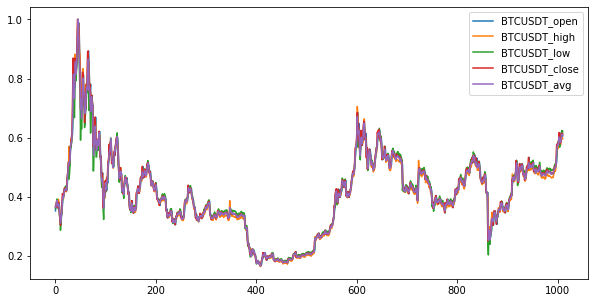

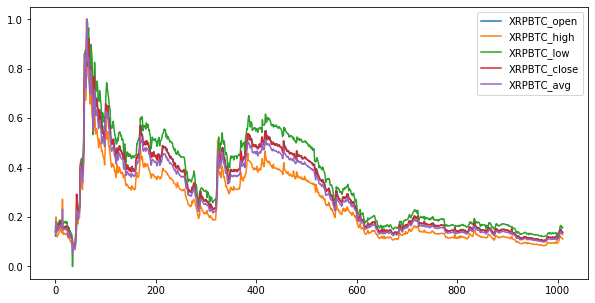

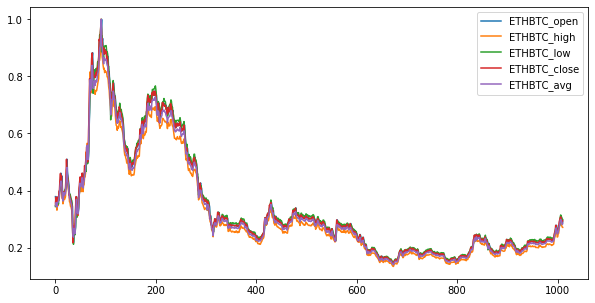

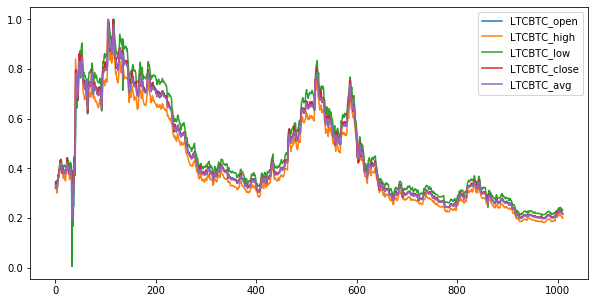

In [5]:
colToShow = []
for c in df.columns:
    if "_avg" in c:
        colToShow.append(c.replace("_avg",""))
        
for c in colToShow:
        p = df[:].plot(use_index=True, y=[c+'_open', c+'_high',c+"_low", c+'_close',c+'_avg'], figsize=(10,5), grid=False)
        wandb.log({"beforeScale_"+c:wandb.Image(p)})
        plt.show()

In [6]:
df

,BTCUSDT_open,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,BTCUSDT_volume,BTCUSDT_close_time,BTCUSDT_quote_av,BTCUSDT_trades,BTCUSDT_tb_base_av,BTCUSDT_tb_quote_av,...,stock market,ethereum,timestampweekday_cos,timestampweekday_sin,timestampday_month_cos,timestampday_month_sin,timestampmonth_year_cos,timestampmonth_year_sin,timestampday_year_cos,timestampday_year_sin
0,0.353238,0.368711,0.361162,0.367487,0.006225,0.945355,0.008416,0.008755,0.005833,0.007865,...,0.146233,0.385417,-0.900969,0.445042,0.978148,0.207912,0.500000,-0.866025,0.512371,-0.858772
1,0.366644,0.371052,0.374014,0.372463,0.004703,0.945409,0.006597,0.006656,0.004001,0.005592,...,0.143279,0.333333,-0.900969,-0.445042,0.913545,0.406737,0.500000,-0.866025,0.527078,-0.849825
2,0.372121,0.377853,0.372825,0.385134,0.003479,0.945463,0.004877,0.005799,0.003232,0.004519,...,0.079764,0.267361,-0.222521,-1.000000,0.809017,0.587785,0.500000,-0.866025,0.541628,-0.840626
3,0.384791,0.383372,0.393248,0.384502,0.003003,0.945518,0.004361,0.004801,0.002737,0.003958,...,0.076809,0.260417,0.623490,-0.801938,0.669131,0.743145,0.500000,-0.866025,0.556017,-0.831178
4,0.384154,0.373813,0.373096,0.364353,0.004383,0.945572,0.006141,0.005855,0.003696,0.005168,...,0.146233,0.291667,1.000000,0.000000,0.500000,0.866025,0.500000,-0.866025,0.570242,-0.821484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.586798,0.576553,0.594273,0.585885,0.145770,0.999784,0.318867,0.373920,0.141063,0.307379,...,0.158050,0.187500,0.623490,0.801938,0.820763,0.571268,-0.866025,-0.500000,-0.843776,-0.536701
1007,0.585349,0.595036,0.599298,0.614831,0.186400,0.999838,0.417398,0.417623,0.182928,0.408004,...,0.155096,0.166667,-0.222521,1.000000,0.688967,0.724793,-0.866025,-0.500000,-0.834438,-0.551107
1008,0.614267,0.601050,0.624662,0.615750,0.157953,0.999892,0.361698,0.398262,0.152113,0.347036,...,0.146056,0.166667,-0.900969,0.445042,0.528964,0.848644,-0.866025,-0.500000,-0.824855,-0.565350
1009,0.615186,0.601552,0.611669,0.606943,0.163490,0.999946,0.371644,0.406976,0.151854,0.343871,...,0.143279,0.166667,-0.900969,-0.445042,0.347305,0.937752,-0.866025,-0.500000,-0.815028,-0.579426


In [7]:
seq_dimen = 60 # two month
t_cut = [int(len(df)*i/100.) for i in [90,95]]
df_train = df[:t_cut[0]]
df_val = df[t_cut[0]-seq_dimen:t_cut[1]]
df_test = df[t_cut[1]-seq_dimen:]
print(len(df_train),len(df_val),len(df_test))

bt_train = bigTweetTensor[:t_cut[0]]
bt_val = bigTweetTensor[t_cut[0]-seq_dimen:t_cut[1]]
bt_test = bigTweetTensor[t_cut[1]-seq_dimen:]
print(len(bt_train),len(bt_val),len(bt_test))

assert len(bt_train)==len(df_train)
assert len(bt_val)==len(df_val)
assert len(bt_test)==len(df_test)

909 111 111
909 111 111


In [8]:
class PricePredDataset(Dataset):
    def __init__(self,flat,df,bt,indxs,history_window=10,prediction_window=[1],pairs={},train=True,minProfit=0.002,useNLP=False):
        super(PricePredDataset).__init__()
        self.useNLP=useNLP
        self.df=df
        self.flat=flat
        self.x=self.df.values.astype(np.float32)
        self.pairs=pairs
        self.train=train
        self.y={};self.y_max={};self.y_min={}
        self.minProfit=minProfit
        self.indxs=indxs
        for p in self.pairs:
            self.y[p]=self.df[p+"_avg"].values.astype(np.float32)
            self.y_max[p]=self.df[p+"_high"].values.astype(np.float32)
            self.y_min[p]=self.df[p+"_low"].values.astype(np.float32)
        self.history_window=history_window
        self.prediction_window=prediction_window
        self.bt=bt
    def __len__(self):
        return len(self.df)-self.history_window-max(self.prediction_window)+1
    def __getitem__(self, idx):
        lastIdx=idx+self.history_window-1
        seq_data=self.x[idx:lastIdx+1]
        seq_data=torch.from_numpy(seq_data[self.indxs,:])
        if(self.useNLP):
            bigt=(self.bt[idx:lastIdx+1,:,:])[self.indxs]
            seq_data=torch.cat((seq_data,bigt.view(bigt.shape[0],-1)),dim=1)
            
        if(self.flat):
            for p in self.pairs:
                seq_data=torch.cat((seq_data.flatten(),torch.from_numpy(self.y[p][idx:lastIdx+1]).flatten()))
        diffPriceMax=[];diffPriceAvg=[];diffPriceMin=[];target=[]
        for pw in self.prediction_window:
            maxPair=[len(self.pairs),self.minProfit]
            for ip,p in enumerate(self.pairs):
                nextPredMax=np.amax(self.y[p][lastIdx+1:lastIdx+pw+1])
                nextPredAvg=np.mean(self.y[p][lastIdx+1:lastIdx+pw+1])
                nextPredMin=np.amin(self.y[p][lastIdx+1:lastIdx+pw+1])
                lastPriceMax=self.y_max[p][lastIdx];lastPriceAvg=self.y[p][lastIdx];lastPriceMin=self.y_min[p][lastIdx];
                diffPriceMax.append((nextPredMax-lastPriceMax)/abs(lastPriceMax))
                diffPriceAvg.append((nextPredAvg-lastPriceAvg)/abs(lastPriceAvg))
                diffPriceMin.append((nextPredMin-lastPriceMin)/abs(lastPriceMin))
                if(diffPriceAvg[-1]>=maxPair[1]):
                    maxPair=[ip,diffPriceAvg[-1]]
            target.append(maxPair[0])
        
        
        result = {'id':idx,'seq_data': seq_data,'target': torch.LongTensor(target)}
        return result

In [9]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim,dropout, output_dim,readoutLayer):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.GRU(input_dim, hidden_dim, layer_dim,dropout=dropout,bidirectional=False, batch_first=True)
        self.fcC = nn.ModuleList()
        for k in range(readoutLayer):
            self.fcC.append(nn.Linear(hidden_dim*(2 if self.rnn.bidirectional else 1), output_dim))

    def forward(self, x):
        self.rnn.flatten_parameters()
        out, _ = self.rnn(x)
        outC =[l(out[:, -1, :]).float() for l in self.fcC]
        return outC

class FCModel(nn.Module):
    def __init__(self, input_dim, hidden_dim,dropout, output_dim,readoutLayer):
        super(FCModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layers=[]
        self.dropx=nn.Dropout(p=0.0, inplace=False)
        for i,h in enumerate(hidden_dim):
            self.layers.append(nn.Linear(in_features=(input_dim if i==0 else hidden_dim[i-1]), out_features=h, bias=True))
            self.layers.append(nn.PReLU())
#             self.layers.append(nn.BatchNorm1d(h, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
            self.layers.append(nn.LayerNorm(h))
            self.layers.append( nn.Dropout(p=dropout[i], inplace=False))
        self.seq=nn.Sequential(*self.layers)
        
        self.readoutC = nn.ModuleList()
        for k in range(readoutLayer):
            self.readoutC.append(nn.Linear(hidden_dim[-1], output_dim))

    def forward(self, x):
        out=self.seq(self.dropx((x.view(x.shape[0],-1))))
        outC=[l(out).float() for l in self.readoutC]
        return outC
    
class ConvModel(nn.Module):
    def __init__(self, input_dim, output_dim,readoutLayer):
        super(ConvModel, self).__init__()
        self.layers=[]
        hl=3
        self.hi=3
        self.start=nn.Linear(in_features=input_dim, out_features=self.hi*self.hi, bias=True)
        self.conv1=nn.Conv2d(in_channels=1,out_channels=hl,kernel_size=3,padding=1)
        self.dr1=nn.Dropout(p=0, inplace=False)
        self.conv2=nn.Conv2d(in_channels=1+hl,out_channels=hl,kernel_size=3,padding=1)
        self.dr2=nn.Dropout(p=0, inplace=False)
        self.conv3=nn.Conv2d(in_channels=1+hl*2,out_channels=hl,kernel_size=3,padding=1)
        self.dr3=nn.Dropout(p=0, inplace=False)
        self.conv4=nn.Conv2d(in_channels=1+hl*3,out_channels=1,kernel_size=3,padding=1)
        self.ac=nn.PReLU()
        
        self.readoutC = nn.ModuleList()
        for k in range(readoutLayer):
            self.readoutC.append(nn.Linear(self.hi*self.hi, output_dim))

    def forward(self, x):
        out=self.start((x.view(x.shape[0],-1)))
        out=out.view(x.shape[0],1,self.hi,self.hi)
        out1=self.ac(self.conv1(out))
        out2=self.ac(self.conv2(torch.cat((out,out1),dim=1)))
        out3=self.ac(self.conv3(torch.cat((out,out1,out2),dim=1)))
        out4=self.ac(self.conv4(torch.cat((out,out1,out2,out3),dim=1)))
        
        out=out4.view(x.shape[0],-1)
        outC=[l(out).float() for l in self.readoutC]
        return outC

In [10]:
def workonbatch(t_loader,mode="Train",wandbLog={},clearO=False,scaleIt=False):
#     gc.collect()
#     torch.cuda.empty_cache()
    torch.autograd.set_grad_enabled(mode=="Train")
    if mode!="Train":
        model.eval()
    else:
        model.train()
    correctP = np.zeros((loopLen))
    totalSum = 0
    totalLoss=[0]
    cm=np.zeros((loopLen,len(pairs)+1,len(pairs)+1))
    torch.set_printoptions(profile="full")
    dsI=0
    totalLen=len(t_loader)
    for idx,ds in enumerate(tqdm(t_loader)):
        dsI+=1
        inp = ds["seq_data"].half().to(avDev)
        if mode=="Train":
            inp+=torch.randn_like(inp)*randomGain
        target = ds["target"].to(avDev)
        lossClass=0;
        # print(target[0],inp[0,0,0])
        optimizer.zero_grad()
        outputs = model(inp)
        for o in range(loopLen):
            lossClass+= cgain*criterions[o](outputs[o], target[:,o])*(1/len(pairs))
            totalLoss[0] += lossClass.item()/len(prediction_window)
                
        if mode=="Train":
            L1_reg = torch.tensor(0., requires_grad=True).to(avDev)
            for name, param in model.named_parameters():
                if 'weight' in name:
                    L1_reg = L1_reg + torch.norm(param, 1)

            loss=lossClass+ L1Gain * L1_reg
            if scaleIt:
                loss*=dsI/len(train_loader)
            loss.backward()
            optimizer.step()
            scheduler.step()
            # print(loss.item())
            
        totalSum += inp.size(0)
        for idP in range(loopLen):
            _, predicted = torch.max(outputs[idP], 1)
            cm[idP]+=confusion_matrix(target[:,idP].view(-1).cpu(), predicted.view(-1).cpu(),labels=range(len(pairs)+1))
            correctP[idP] += (predicted == target[:,idP]).sum().cpu().numpy()
            
    acc_t = 100. * correctP / totalSum
    wandbLog = {**wandbLog, **{mode+"_loss_"+str(i):totalLoss[i]/len(t_loader) for i in range(len(totalLoss))}}
    wandbLog[mode+"_acc"] = acc_t.mean()
    if clearO:
         clear_output(wait=True)
    print(mode+': Iteration: {}/{}. Loss: {}.'.format(i,epochs, list(map(lambda x: x /len(t_loader), totalLoss))))
    for idP in range(loopLen):
        whichP=idP//len(prediction_window)
        whichW=idP%len(prediction_window)
        print(mode,pairs[whichP],prediction_window[whichW],acc_t[idP])
        wandbLog[mode+"_cm_"+str(idP)]=show_confusion_matrix(cm[idP],show=True)
        
    return acc_t, cm, wandbLog

def modolo(idx,lenarr,gain,maxidx):
    if idx>maxidx:
        return True
    gain=max(1,gain)
    return idx%int(max(1,math.floor(gain*lenarr/(idx+1))))==0

In [11]:
modelArch="FC"#"CNN","FC","RNN"
useNLP=True
input_dimen = len(df_train.columns)
if useNLP:
    input_dimen+=tweetDim
pairs=["BTCUSDT"]
hidden_dimen = [250,120,50,20] if modelArch=="FC" else 50
dropout_fc=[0.0,0.0,0.0,0.0]  if modelArch=="FC" else 0.1
layer_dimen = 2
batch_size_ds = 20
prediction_window=[3]
prediction_window_test=prediction_window
minProfit=0.015
minProfitTest=0.015
output_dimen = len(pairs)+1
loopLen=len(prediction_window)
addPrice=False 
addPrice=addPrice and modelArch!="RNN"
print(addPrice)
# indexes=np.array([i for i in range(seq_dimen) if modolo(i,seq_dimen,5,seq_dimen-25)])
indexes=np.array([i for i in range(seq_dimen)])
print(indexes)
print(indexes.shape)

if modelArch!="RNN":
    input_dimen*=len(indexes)
    if addPrice:
        input_dimen+=(len(pairs)*seq_dimen)
        
avDev = torch.device("cpu")
if torch.cuda.is_available():
    cuda_devices = [0]
    avDev = torch.device("cuda:"+str(cuda_devices[0]))
    if(len(cuda_devices) > 0):
        torch.cuda.set_device(cuda_devices[0])

if modelArch=="RNN":
    model = RNNModel(input_dimen, hidden_dimen, layer_dimen,dropout_fc, output_dimen,len(prediction_window)).to(avDev)
elif modelArch=="FC":
    model = FCModel(input_dimen,hidden_dimen ,dropout_fc, output_dimen,len(prediction_window)).to(avDev)
else:
    model = ConvModel(input_dimen,output_dimen,len(prediction_window)).to(avDev)
    

train_loader = torch.utils.data.DataLoader(dataset = PricePredDataset(addPrice,df_train[int(len(df_train)*0.):],bt_train[int(len(df_train)*0.):],indexes,seq_dimen,prediction_window,pairs,True,minProfit,useNLP=useNLP),
                                           num_workers=4, batch_size = batch_size_ds, shuffle = True,pin_memory=False)
val_loader = torch.utils.data.DataLoader(dataset = PricePredDataset(addPrice,df_val,bt_val,indexes,seq_dimen,prediction_window_test,pairs,False,minProfitTest,useNLP=useNLP),
                                          num_workers=4, batch_size = batch_size_ds, shuffle = False,pin_memory=False)
test_loader = torch.utils.data.DataLoader(dataset = PricePredDataset(addPrice,df_test,bt_test,indexes,seq_dimen,prediction_window_test,pairs,False,minProfitTest,useNLP=useNLP),
                                          num_workers=4, batch_size = batch_size_ds, shuffle = False,pin_memory=False)


def somePortion(dl,st=0,en=1):
    dstl=PricePredDataset(addPrice,df_train[int(len(dl.dataset)*st):int(len(dl.dataset)*en)],bt_train[int(len(dl.dataset)*st):int(len(dl.dataset)*en)],indexes,seq_dimen,prediction_window,pairs,True,minProfit,useNLP=useNLP)
    return torch.utils.data.DataLoader(dataset = dstl,
                                               num_workers=dl.num_workers, batch_size = batch_size_ds,pin_memory=dl.pin_memory
                                               ,shuffle=True)
# urllib.request.urlretrieve("https://app.hmojtaba.xyz/csv_60/Cmodel_MATICBTC_61_{200.0_123.0}_Val_55.0___47_{1091.0_1230.0}_Tes_49.4.gz","model.gz" )
# model=joblib.load("model.gz")["model"]



if torch.cuda.device_count() > 1 and not isinstance(model,nn.DataParallel) and False:
    multiG=True
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    
multiG=isinstance(model,nn.DataParallel)
def getModel():
    if multiG:
        return model.module
    else:
        return model
    
def getDictToSave(acc_train=None,cm_train=None,acc_test=None,cm_test=None):
    return {
    "model":copy.deepcopy(getModel()).cpu(),
    "min_max_scaler":min_max_scaler,
    "pairs":pairs,
    "modelArch":modelArch,
    "input_dimen":input_dimen,
    "hidden_dimen":hidden_dimen,
    "layer_dimen":layer_dimen,
    "seq_dimen":seq_dimen,
    "indexes":indexes,
    "prediction_window":prediction_window,
    "prediction_window_test":prediction_window_test,
    "acc_train":acc_train,
    "cm_train":cm_train,
    "acc_val":acc_val,
    "cm_val":cm_val,
    "weightTarget":weightTarget,
    "weightTargetVal":weightTargetVal,
    "weightTargetTest":weightTargetTest,
    "column_names_to_normalize":column_names_to_normalize,
    "minProfit":minProfit,
    "minProfitTest":minProfitTest,
    "addPrice":addPrice
    }
    
model=model.to(avDev)

print(avDev)
print(model)

False
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
(60,)
cuda:0
FCModel(
  (dropx): Dropout(p=0.0, inplace=False)
  (seq): Sequential(
    (0): Linear(in_features=1480440, out_features=250, bias=True)
    (1): PReLU(num_parameters=1)
    (2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=250, out_features=120, bias=True)
    (5): PReLU(num_parameters=1)
    (6): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
    (7): Dropout(p=0.0, inplace=False)
    (8): Linear(in_features=120, out_features=50, bias=True)
    (9): PReLU(num_parameters=1)
    (10): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (11): Dropout(p=0.0, inplace=False)
    (12): Linear(in_features=50, out_features=20, bias=True)
    (13): PReLU(num_parameters=1)
    (14): LayerNorm((20,), eps=1e-05

In [12]:
def myDescribeDS(ds,name):
    print(name)
    total=0
    cc=torch.zeros(loopLen,len(pairs)+1)
    for d in tqdm(ds):
        total+=(len(d["seq_data"]))
        for idP in range(loopLen):
            uidx,uvalue=torch.unique(d["target"][:,idP], return_counts=True)
            cc[idP,uidx]+=uvalue

    res=cc.max(dim=1)[0].view(loopLen,1).expand(loopLen,len(pairs)+1)/(cc+1)
    torch.set_printoptions(sci_mode=False)
    print("total:",total)
    print("range:",cc)
    print("weight:",res)
    print("-----------")
    torch.set_printoptions(sci_mode=None)
    return res,cc

weightTarget=myDescribeDS(train_loader,"Train")
weightTargetVal=myDescribeDS(val_loader,"Val")
weightTargetTest=myDescribeDS(test_loader,"Test")

Train



total: 847
range: tensor([[271., 576.]])
weight: tensor([[2.1176, 0.9983]])
-----------
Val



total: 49
range: tensor([[19., 30.]])
weight: tensor([[1.5000, 0.9677]])
-----------
Test



total: 49
range: tensor([[16., 33.]])
weight: tensor([[1.9412, 0.9706]])
-----------


In [13]:
gc.collect()
for p in model.parameters():
    if p.grad is not None:
        del p.grad  # free some memory
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.cuda.empty_cache()

In [14]:
bestTest=0

In [15]:
lr=0.001
epochs=200000000000
weightT=weightTarget[0].clone()
# weightT[0,-1]=30
L1Gain=0.0000
if modelArch=="FC":
    getModel().seq[3].p=0.8
    getModel().seq[7].p=0.8
    getModel().seq[11].p=0.5    
    getModel().seq[15].p=0.3
    getModel().dropx.p=0.
#     getModel().seq[7].p=0.1
elif modelArch=="CNN":
    getModel().dr1.p=0.
    getModel().dr2.p=0.
    getModel().dr3.p=0.
else:    
    getModel().rnn.dropout=0.1
    
randomGain=0.00035
criterions = [nn.CrossEntropyLoss(weight=weightT[i,:]).to(avDev) for i in range(loopLen)]

# criterions = [nn.CrossEntropyLoss().to(avDev) for i in range(loopLen)]
criterionReg = nn.MSELoss().to(avDev)
optimizer = torch.optim.SGD(model.parameters(), lr=lr,weight_decay=0.01) #,eps=1e-4 #https://arxiv.org/abs/1712.07628
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)


model.half()
for layer in model.modules():
    if isinstance(layer, nn.BatchNorm1d) or isinstance(layer, nn.BatchNorm2d):
        layer.float()
    
print(model)

FCModel(
  (dropx): Dropout(p=0.0, inplace=False)
  (seq): Sequential(
    (0): Linear(in_features=1480440, out_features=250, bias=True)
    (1): PReLU(num_parameters=1)
    (2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.8, inplace=False)
    (4): Linear(in_features=250, out_features=120, bias=True)
    (5): PReLU(num_parameters=1)
    (6): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
    (7): Dropout(p=0.8, inplace=False)
    (8): Linear(in_features=120, out_features=50, bias=True)
    (9): PReLU(num_parameters=1)
    (10): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=50, out_features=20, bias=True)
    (13): PReLU(num_parameters=1)
    (14): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (15): Dropout(p=0.3, inplace=False)
  )
  (readoutC): ModuleList(
    (0): Linear(in_features=20, out_features=2, bias=True)
  )
)


Train: Iteration: 3095/200000000000. Loss: [0.6933339104056359].
Train BTCUSDT 3 67.13375796178345


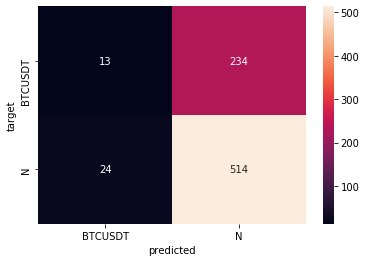


Validation: Iteration: 3095/200000000000. Loss: [0.6955468853314718].
Validation BTCUSDT 3 61.224489795918366


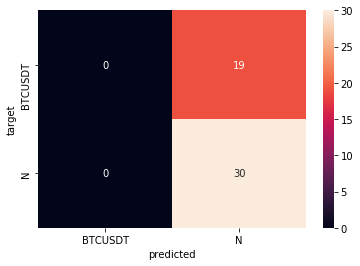

Validation avg acc: 61.224489795918366
Train avg acc: 67.13375796178345
0 100


In [ ]:
def perc(cm_val):
    return 100*(cm_val[0,0,0]/(cm_val[0,1,0]+cm_val[0,0,0]+0.1))
def strRep(cm_val):
    return str(int(perc(cm_val)))+"_{"+str(cm_val[0,0,0])+"_"+str(cm_val[0,1,0])+"}"
cgain = 1
scaleIt = False
for i in tqdm(range(epochs)):
    st = 0#random.randint(0,70)
    en = 100#random.randint(st+20,100)
    print(st,en)
    wandbLog = {}
    acc_train, cm_train, wandbLog = workonbatch(somePortion(train_loader,st/100.,en/100.),"Train",wandbLog,True,scaleIt)
    acc_val, cm_val, wandbLog = workonbatch(val_loader,"Validation",wandbLog,False,False)
    valueToTrack = perc(cm_val) #acc_val.mean()
    wandbLog["valueToTrack_validation"] = valueToTrack
    print("Validation avg acc:",acc_val.mean())
    print("Train avg acc:",acc_train.mean())
    if(valueToTrack>bestTest):
        acc_test, cm_test, wandbLog=workonbatch(test_loader,"Test",wandbLog,False,False)
        print("Test avg acc:",acc_test.mean())
        bestTest = valueToTrack
        fileN = "Cmodel_"+"_".join(pairs)+"_"+strRep(cm_val)+"_Val_"+str(int(acc_val.mean()*10)/10.)+"___"+strRep(cm_test)+"_Tes_"+str(int(acc_test.mean()*10)/10.)
        show_confusion_matrix(cm_val[0],fileN+"_val.png", show=False)
        show_confusion_matrix(cm_test[0],fileN+"_tes.png", show=False)
        print("Saved!",fileN+".gz")
        joblib.dump(getDictToSave(acc_train,cm_train,acc_val,cm_val), fileN+".gz")
#         wandb.save(fileN+".gz")
        
    wandb.log(wandbLog)
#     time.sleep(3)
